<a href="https://www.kaggle.com/code/baotranquoc685/s-p500-stocks-analysis?scriptVersionId=200220866" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/baotranquoc685/s-p500-stocks-analysis?scriptVersionId=199874143" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# S&P 500 Stocks Analysis
## Goal: Analyze the Stock Values of S&P 500 by Statistical Models

In [1]:
# for data manipulation
import pandas as pd
import numpy as np
# for plotting
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go # note that github wont be able to display these plots because they are interactive
# for some processing
import math
from datetime import datetime, timedelta

## 1. Import files

#### We gather 3 sets of data:
####  - df_companies: the data set of the information of the 500 companies in S&P 500
####  - df_index: the index value of S&P 500 from 2014 until now
####  - df_stocks: the value of a stock for every company in S&P 500 from 2014 until now

In [2]:
df_companies = pd.read_csv("/kaggle/input/sp500-september-2024/sp500_companies.csv")
df_companies

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,229.00,3481738936320,1.317810e+11,0.049,Cupertino,CA,United States,161000.0,"Apple Inc. designs, manufactures, and markets ...",0.066419
1,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,417.14,3100618260480,1.294330e+11,0.152,Redmond,WA,United States,228000.0,Microsoft Corporation develops and supports so...,0.059148
2,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,119.37,2928146120704,6.118400e+10,1.224,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.055858
3,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,163.38,2021272190976,1.154780e+11,0.136,Mountain View,CA,United States,179582.0,Alphabet Inc. offers various products and plat...,0.038558
4,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,165.11,2020401479680,1.154780e+11,0.136,Mountain View,CA,United States,179582.0,Alphabet Inc. offers various products and plat...,0.038542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,NYQ,IVZ,Invesco Ltd,Invesco Ltd.,Financial Services,Asset Management,17.09,7691046912,1.050800e+09,0.028,Atlanta,GA,United States,8536.0,Invesco Ltd. is a publicly owned investment ma...,0.000147
499,NMS,PARA,Paramount Global,Paramount Global,Communication Services,Entertainment,10.47,7457582592,2.979000e+09,-0.105,New York,NY,United States,21900.0,"Paramount Global operates as a media, streamin...",0.000142
500,NMS,AAL,"American Airlines Group, Inc.",American Airlines Group Inc.,Industrials,Airlines,10.62,6974196224,5.150000e+09,0.020,Fort Worth,TX,United States,137400.0,"American Airlines Group Inc., through its subs...",0.000133
501,NYQ,BBWI,"Bath & Body Works, Inc.","Bath & Body Works, Inc.",Consumer Cyclical,Specialty Retail,30.76,6739885056,1.568000e+09,-0.021,Columbus,OH,United States,8981.0,"Bath & Body Works, Inc. operates a specialty r...",0.000129


In [3]:
df_index = pd.read_csv("/kaggle/input/sp500-september-2024/sp500_index.csv")
df_index

,Date,S&P500
0,2014-09-02,2002.28
1,2014-09-03,2000.72
2,2014-09-04,1997.65
3,2014-09-05,2007.71
4,2014-09-08,2001.54
...,...,...
2512,2024-08-26,5616.84
2513,2024-08-27,5625.80
2514,2024-08-28,5592.18
2515,2024-08-29,5591.96


In [4]:
df_stocks = pd.read_csv("/kaggle/input/sp500-september-2024/sp500_stocks.csv")
df_stocks

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,44.016735,69.414719,69.774246,69.122070,69.473244,3640265.0
1,2010-01-05,MMM,43.741028,68.979935,69.590302,68.311035,69.230766,3405012.0
2,2010-01-06,MMM,44.361351,69.958191,70.735786,69.824417,70.133781,6301126.0
3,2010-01-07,MMM,44.393162,70.008362,70.033447,68.662209,69.665550,5346240.0
4,2010-01-08,MMM,44.705971,70.501671,70.501671,69.648827,69.974915,4073337.0
...,...,...,...,...,...,...,...,...
1856065,2024-08-26,ZTS,181.559998,181.559998,182.589996,180.520004,181.039993,1015900.0
1856066,2024-08-27,ZTS,182.100006,182.100006,183.089996,181.419998,181.979996,1423900.0
1856067,2024-08-28,ZTS,182.910004,182.910004,184.610001,182.100006,182.100006,1485400.0
1856068,2024-08-29,ZTS,182.889999,182.889999,184.710007,182.479996,183.910004,1359900.0


## 1.1. Clean the Dataset

### a) S&P 500 Companies Dataset

In [5]:
# handle empty string
# Exchange, Symbol, Shortname, Longname, Sector, Industry, City, State, Country, Longbusinesssummary
companies_columns_to_check = ["Exchange", "Symbol", "Shortname", "Longname", "Sector", "Industry", "City", "State", "Country", "Longbusinesssummary"]
df_companies[companies_columns_to_check] = df_companies[companies_columns_to_check].replace('', np.nan)
df_companies = df_companies.dropna(subset = companies_columns_to_check)

In [6]:
# handle NaN values
# Currentprice, Marketcap, Ebitda, Revenuegrowth, Fulltimeemployees, Weight
companies_columns_to_fill = ["Currentprice", "Marketcap", "Ebitda", "Revenuegrowth", "Fulltimeemployees", "Weight"]
# we want to fill it with the median rather than using ffill
df_companies.loc[:, companies_columns_to_fill] = df_companies[companies_columns_to_fill].apply(lambda col: col.fillna(col.median()))
print(df_companies.shape)

(484, 16)


### b) S&P 500 Index Dataset

In [7]:
# handle empty string
# Date
# we drop the rows with empty date
df_index["Date"] = df_index["Date"].replace('', np.nan)
df_index = df_index.dropna(subset = ["Date"])

In [8]:
# handle NaN value
# S&P500
# we use ffill which fill the NaN row with the previous row's value
# note that using ffill here makes sense because the data is a time-series so the previous value should be very close to the missing value
df_index["S&P500"] = df_index["S&P500"].ffill()
print(df_index.shape)

(2517, 2)


### c) S&P 500 Stocks Dataset

In [9]:
# handle empty string
# Date, Symbol
stocks_columns_to_check = ["Date", "Symbol"]
df_stocks[stocks_columns_to_check] = df_stocks[stocks_columns_to_check].replace('', np.nan)
df_stocks = df_stocks.dropna(subset = stocks_columns_to_check)

In [10]:
# handle NaN value
# Adj Close, Close, High, Low, Open, Volume
# we use ffill
stocks_columns_to_fill = ["Adj Close", "Close", "High", "Low", "Open", "Volume"]
df_stocks.loc[:, stocks_columns_to_fill] = df_stocks[stocks_columns_to_fill].ffill()
print(df_stocks.shape)

(1856070, 8)


## 2. S&P500 Index Value Plot

In [11]:
template = "seaborn"

In [12]:
def index_value_by_date_plot():
  # note that df_index must contain "Date" and "S&P500" column
  fig = px.line(
    df_index,
    x = "Date",
    y = "S&P500",
    title = "S&P500 Index Value",
    template = template
  )
  # get the button for the time period, making the plot interactive
  fig.update_xaxes(
    rangeslider_visible = False,
    rangeselector = dict(
      buttons = list([
        dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
        dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
        dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
        dict(count = 5, label = "5y", step = "year", stepmode = "backward"),
        dict(step = "all")
      ])
    ),
  )

  fig.show()

index_value_by_date_plot()

In [13]:
def get_year_open_close(df):
  year_open = df.loc[df["Date"].idxmin(), "S&P500"]
  year_close = df.loc[df["Date"].idxmax(), "S&P500"]
  return pd.Series({"Year_open": year_open, "Year_close": year_close})

def index_annual_return_plot():
  year_lis = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
  df_index_cp = df_index.copy()
  df_index_cp["Date"] = pd.to_datetime(df_index_cp["Date"])
  df_index_cp["Year"] = df_index_cp["Date"].dt.year
  df_index_filtered = df_index_cp[df_index_cp["Year"].isin(year_lis)] # get only the features that is in the year of year_lis
  # now we get the open and close value of each year
  df_index_year = df_index_filtered.groupby("Year").apply(get_year_open_close, include_groups = False).reset_index().sort_values(by = "Year", ascending = True)
  # calculate annual return by (year_close - year_open) / year_open
  df_index_year["Annual_return_rate"] = (df_index_year["Year_close"] - df_index_year["Year_open"]) / df_index_year["Year_open"]
  # plot
  fig = px.bar(
    df_index_year,
    x = "Year",
    y = "Annual_return_rate",
    barmode = "stack",
    labels = {"Year": "Year", "Annual_return_rate": "Annual Return Rate"},
    title = f"Annual Return Rate of S&P 500 from {year_lis[0]} to {year_lis[-1]}",
    template = template
  )
  fig.update_xaxes(tickmode = "linear")
  fig.update_layout(showlegend = False)
  fig.show()
  # calculate annual return rate from the whole period
  total_annual_return_rate = df_index_year["Annual_return_rate"].sum() * 100
  average_annual_return_rate = total_annual_return_rate / len(year_lis)
  print(f"Total Annual Return Rate is {total_annual_return_rate:.2f}%")
  print(f"Average Annual Return Rate is {average_annual_return_rate:.2f}%")
index_annual_return_plot()


Total Annual Return Rate is 102.36%
Average Annual Return Rate is 10.24%


#### While the stock is not changing too much in a 1-month period and 6-month period, we can see that it is increasing gradually from 2014 to now.
#### There was a sudden drop in 2020 (hypothetically because of the COVID pandemic), but the annual return rate is still positive, meaning the economy was doing well recovering from the pandemic.
#### Over the five-year period from September 2013 to September 2023, the stock experienced a total annual return rate of 102.36%, representing an average annual growth rate of 10.24%.

## 3. Market Cap Analysis

## 3.1. Market Cap by Sector Plot

In [14]:
def marketcap_by_sector_plot():
  # group the features into their sector, then sum up the marketcap, then reset_index, then sort them by marketcap in descending order
  df_sector_marketcap = df_companies.groupby("Sector").agg({"Marketcap": "sum"}).reset_index().sort_values(by = "Marketcap", ascending = False)
  fig = px.bar(
    df_sector_marketcap,
    x = "Sector",
    y = "Marketcap",
    barmode = "stack",
    labels = {"Sector": "Sector", "Marketcap": "Market Cap"},
    title = "Market Cap by Sector",
    template = template
  )
  fig.update_layout(showlegend = False)
  fig.show()

marketcap_by_sector_plot()

#### The Technology sector commands the largest market capitalization, followed by Communication Services and Financial Services. Real Estate and Basic Materials exhibit the lowest market capitalization.
#### The reason for this can be the fact that technogolies are the leading industry for the modern world.

## 3.2. Market Cap by Industry Plot

In [15]:
def marketcap_by_industry_plot(sector, fig):
  # get all the companies within the sector
  df_current_companies = df_companies[df_companies["Sector"] == sector]
  unique_industries = len(df_current_companies["Industry"].unique())
  # group the features (companies) into their Industry, then sum up the marketcap, then reset_index, then sort them according to the marketcap in descending order
  df_industry_marketcap = df_current_companies.groupby("Industry").agg({"Marketcap": "sum"}).reset_index().sort_values(by = "Marketcap", ascending = False)
  fig.add_trace(
    go.Bar(
      x = df_industry_marketcap["Industry"],
      y = df_industry_marketcap["Marketcap"],
      name = sector,
    )
  )

def marketcap_by_multiple_industry_plot():
  # get the unique sectors
  unique_sectors = df_companies["Sector"].unique()
  fig = go.Figure()
  # loop over the sectors and plot their industry
  for sector in unique_sectors:
    marketcap_by_industry_plot(sector, fig)
  # update layout
  fig.update_layout(
    title = "Market Cap of the Industries of the 11 Sectors",
    xaxis_title = "Industries",
    yaxis_title = "Market Cap",
    template = template
  )
  fig.show()
  
marketcap_by_multiple_industry_plot()


#### Each sector has multiple industries, for example Techonology has Semiconductors, Consumer Electronics, etc.
#### Techonology and Communication Services are the leading sectors regarding market capitalization.
#### The Consumer Cyclical and Industrials sectors boast the most diverse range of industries, with 19 each. In contrast, the Energy sector is relatively narrow, encompassing only 5 industries.

## 3.3. Min-Max Market Cap by Industry Plot

In [16]:
def minmax_marketcap_by_industry_plot(sector, fig):
  def get_minmax_marketcap(df):
    # get the two rows
    marketcap_min = df.loc[df["Marketcap"].idxmin(), :]
    marketcap_max = df.loc[df["Marketcap"].idxmax(), :]
    # concat the rows so that we have a dataframe that has only the marketcap min and marketcap max
    return pd.concat([marketcap_max, marketcap_min], axis = 1).T

  # get all the companies within the current sector
  df_current_companies = df_companies[df_companies["Sector"] == sector]
  df_industry_marketcap = df_current_companies.groupby("Industry").agg({"Marketcap": "sum"}).reset_index()
  minmax_marketcap = get_minmax_marketcap(df_industry_marketcap)
  
  fig.add_trace(
    go.Bar(
      x = minmax_marketcap["Industry"],
      y = minmax_marketcap["Marketcap"],
      name = sector,
    )
  )

def minmax_marketcap_by_multiple_industry_plot():
  fig = go.Figure()

  unique_sectors = df_companies["Sector"].unique()
  for sector in unique_sectors:
    minmax_marketcap_by_industry_plot(sector, fig)

  fig.update_layout(
    title_text = "Min-Max Market Cap by Industry",
    xaxis_title = "Industry",
    yaxis_title = "Market Cap",
    template = template
  )
  fig.show()

minmax_marketcap_by_multiple_industry_plot()

#### There is a huge discrepency in the market capitalization between the industries (sub-sector) for all of the sectors. So the market capitalization of a sector highly depends on one of its industries.
#### In the Technology sector, Semiconductors's market capitalization is 120 times Internet Retail's market capitalization. And, the disprepency in the Real Estate is minimal, where REIT - Specialty's market capitalization is merely 15.9 times REIT - Hotel & Motel.

## 3.4. Market Cap by Full-time Employees Plot

In [17]:
def marketcap_by_fulltime_employee_plot():
  fig = px.scatter(
    df_companies,
    x = "Fulltimeemployees",
    y = "Marketcap",
    hover_name = "Shortname",
    labels = {"Fulltimeemployees": "Full-time Employees", "Marketcap": "Market Cap"},
    title = "Market Cap by Full-time Employees",
    color = "Shortname",
    template = template
  )
  fig.update_layout(showlegend = False)
  fig.show()

marketcap_by_fulltime_employee_plot()

#### The majority of companies have less than 500,000 full-time employees and less than $500 million in market capitalization.
#### Walmart and Amazon are the two companies with the most full-time employees while Apple and Microsoft are the two with largest market cap.

## 3.5. Market Cap by City Plot

In [18]:
def marketcap_by_city_plot():
  # get each city total marketcap and sort them in decreasing order
  df_city_marketcap = df_companies.groupby("City").agg({"Marketcap": "sum"}).reset_index().sort_values(by = "Marketcap", ascending = False)
  fig = px.bar(
    df_city_marketcap,
    x = "City",
    y = "Marketcap",
    barmode = "stack",
    labels = {"City": "City", "Marketcap": "Market Cap"},
    title = "Market Cap by City",
    template = template
  )
  fig.show()

marketcap_by_city_plot()

#### Mountain View, Santa Clara, and Cupertino are the cities with the highest market capitalization (mainly because of the headquarter of the companies such as Microsoft, Apple, Nvidia, Amazon).

## 3.6. Annual Return Rate by Sector Plot

In [19]:
def annual_return_by_sector(year_lis):
  df_stocks_cp = df_stocks.copy()
  df_stocks_cp["Date"] = pd.to_datetime(df_stocks_cp["Date"]) # convert the date into object format
  df_stocks_cp["Year"] = df_stocks_cp["Date"].dt.year
  df_stocks_filtered = df_stocks_cp[df_stocks_cp["Year"].isin(year_lis)] # get only the features (rows) that is in the time interval of year_lis

  def get_year_open_close(df):
    year_open = df.loc[df["Date"].idxmin(), "Open"]
    year_close = df.loc[df["Date"].idxmax(), "Close"]
    return pd.Series({"Year_open": year_open, "Year_close": year_close})
  
  # we get the open and close value of each stock for the years in year_lis
  # note that after .apply, only the Symbol, Year, Year_open, Year_close column are in df_year_stocks DataFrame, similar to .agg above
  df_year_stocks = df_stocks_filtered.groupby(["Symbol", "Year"]).apply(get_year_open_close, include_groups = False).reset_index().sort_values(by = "Year", ascending = True)
  
  # now we need to add Year_open and Year_close to df_companies to know which sector, industry the companies are in
  k = len(year_lis)
  df_companies_expand = df_companies.loc[df_companies.index.repeat(k)] # repeat each row in df_companies k times
  df_companies_expand["Year"] = year_lis * len(df_companies) # add the Year column, resulting in a dataframe that for each company, there are k rows

  # now we merge the two dataframes together
  df_merge = pd.merge(df_year_stocks, df_companies_expand, on = ["Symbol", "Year"], how = "left")
  # calculate the annual return
  df_merge["Annual_return_rate"] = (df_merge["Year_close"] - df_merge["Year_open"]) / df_merge["Year_open"]

  # loop through the year_lis and plot
  for year in year_lis:
    df_current_year = df_merge.loc[df_merge["Year"] == year]
    df_sector_annual_return = df_current_year.groupby("Sector").agg({"Annual_return_rate": "mean"}).reset_index()

    fig = go.Figure()

    for index, row in df_sector_annual_return.iterrows():
      sector = row["Sector"]
      annual_return_rate = row["Annual_return_rate"]
      fig.add_trace(
        go.Bar(
          x = [sector],
          y = [annual_return_rate],
          name = sector
        )
      )
    fig.update_layout(
      title = f"Annual Return by Sector - {year}",
      xaxis_title = "Sector",
      yaxis_title = "Annual Return Rate",
      barmode = "group",
      template = template
    )
    fig.show()
  
annual_return_by_sector([2019, 2020, 2021, 2022, 2023,])


#### The market experienced its most robust annual returns in 2019 and 2021, with all sectors having positive returns exceeding 0.1%. While 2020 and 2023 demonstrated a decent performance, 2022 was the challenging year marked by significant annual returns accross most sectors, with the exception of Energy.
#### Between 2019 and 2023, the Energy and Technology sectors exhibited the most robust performance.

## 4. Top Five Market Capitalization Companies Analysis

In [20]:
def top_ten_marketcap_companies(days):
  # unique the companies
  df_unique_companies = df_companies.drop_duplicates(subset = "Shortname")
  # get the top ten unique companies
  df_top_ten_companies = df_unique_companies.sort_values(by = "Marketcap", ascending = False).iloc[0: 10]
  # print out the top ten marketcap companies
  print(df_top_ten_companies[["Symbol", "Shortname"]])
  df_stocks_cp = df_stocks.copy()
  # get the index of these companies
  df_stocks_filtered = df_stocks_cp[df_stocks_cp["Symbol"].isin(df_top_ten_companies["Symbol"])]
  # only use the data within one year from now
  df_stocks_filtered.loc[:, "Date"] = pd.to_datetime(df_stocks_filtered["Date"]) # the .loc here is to edit the originnal df_stocks_cp to avoid ambiguity
  # get the begin date
  end = datetime.today()
  begin = end - timedelta(days = days)
  df_stocks_filtered = df_stocks_filtered[df_stocks_filtered["Date"] >= begin]
  
  return df_stocks_filtered

## 4.1 Adjusted Close Price Plot

   Symbol                    Shortname
0    AAPL                   Apple Inc.
1    MSFT        Microsoft Corporation
2    NVDA           NVIDIA Corporation
3   GOOGL                Alphabet Inc.
5    AMZN             Amazon.com, Inc.
6    META         Meta Platforms, Inc.
7   BRK-B  Berkshire Hathaway Inc. New
8     LLY        Eli Lilly and Company
9    AVGO                Broadcom Inc.
10   TSLA                  Tesla, Inc.


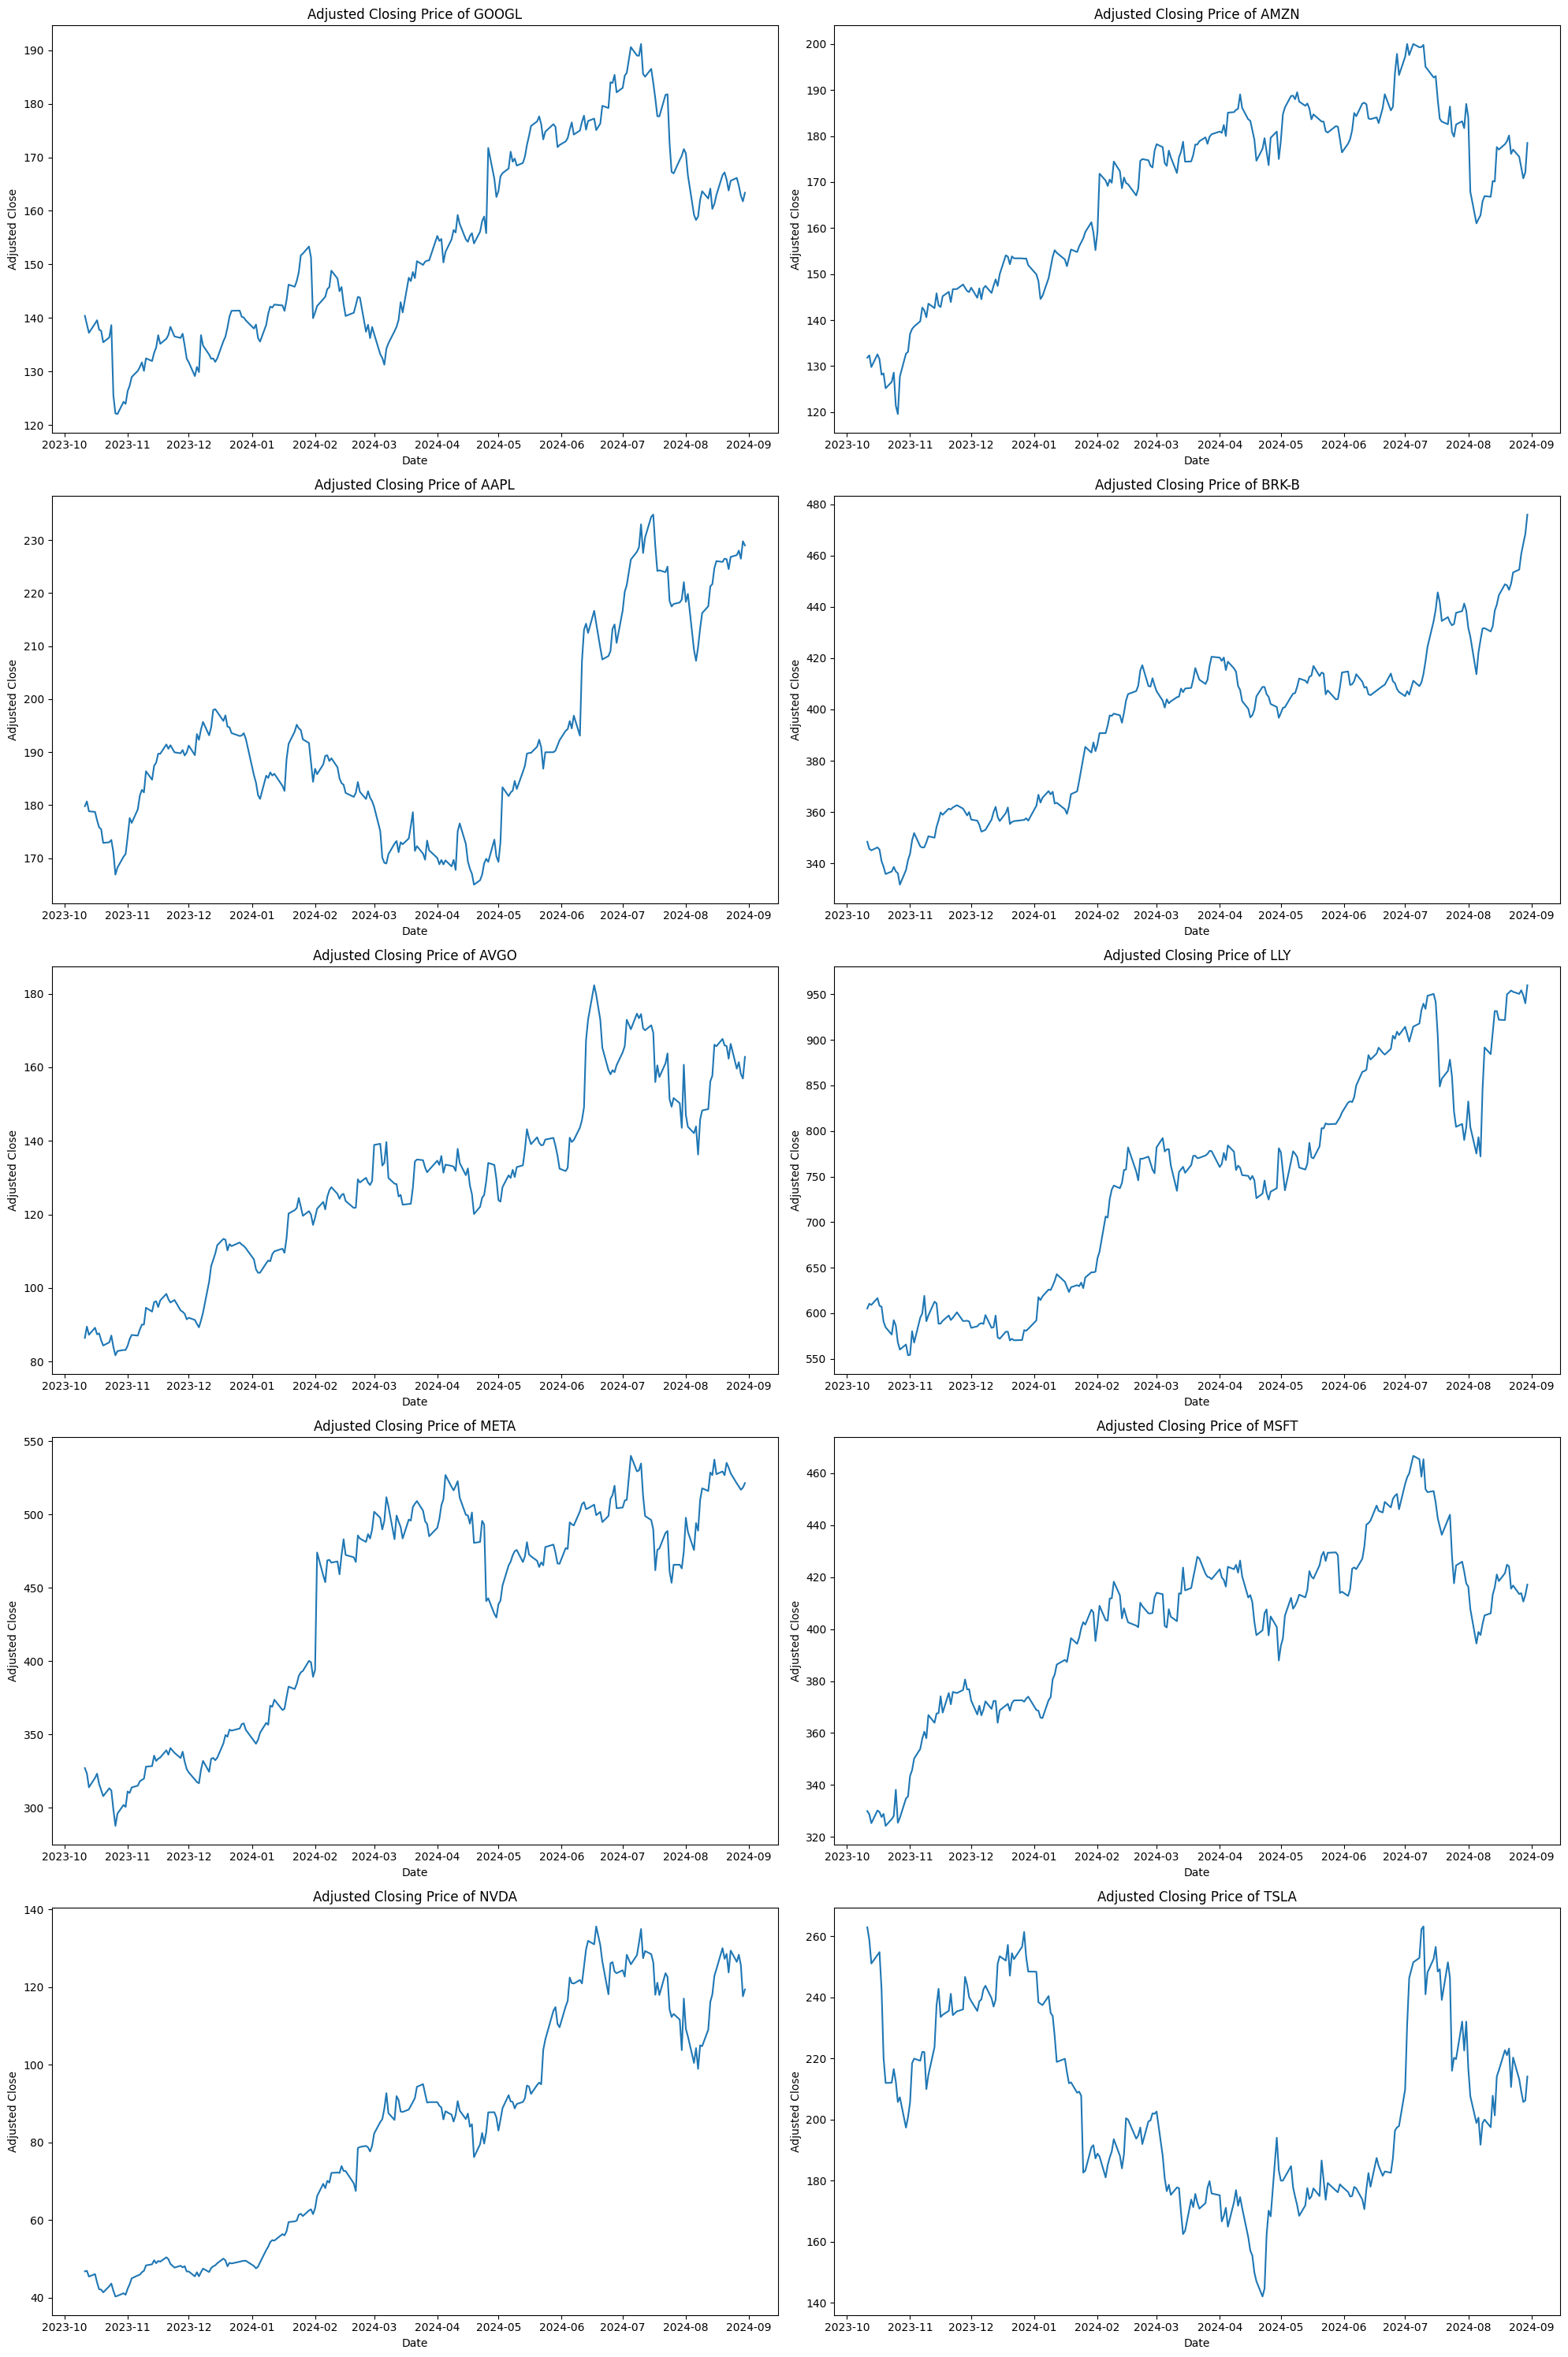

In [21]:
def adj_close_by_date_plot():
  df_stocks_filtered = top_ten_marketcap_companies(365)
  # get the unique companies' symbols
  company_lis = df_stocks_filtered["Symbol"].unique()
  k = len(company_lis)
  number_of_row = math.ceil(k / 2)
  # init plot
  fig, ax = plt.subplots(number_of_row, 2, figsize = (20, 30))
  
  # loop over the companies and plot the adj close by date plots
  for index, company_symbol in enumerate(company_lis, start = 0):
    # get the data correspond to the current company
    df_current_stocks_filtered = df_stocks_filtered[df_stocks_filtered["Symbol"] == company_symbol]
    # plot
    i = index // 2
    j = index % 2
    ax[i, j].plot(df_current_stocks_filtered["Date"], df_current_stocks_filtered["Adj Close"])
    ax[i, j].set_xlabel("Date")
    ax[i, j].set_ylabel("Adjusted Close")
    ax[i, j].set_title(f"Adjusted Closing Price of {company_symbol}")
  
  plt.tight_layout()
  plt.show()

adj_close_by_date_plot()

#### The closing price of Google, Amazon, Apple, Eli Lilly, Meta, Microsoft, Nvidia and Tesla was increasing from September 2023 to July 2024. In July and August of 2024, all of the listed companies experienced a sudden drop in value. Then in September, they recovered but did not reach the peak price before the drop.
#### It is worth to note that all of these companies are in the Technology sector. So the reason for the sudden drop could be the Intel 13th and 14th gen chip crisis.
#### The closing price of Berkshire Hathaway was increasing in the period of Sep 2023 to July 2024 and experienced so sudden drop like the ones in the Technology sector.

## 4.2 Volume Plot

   Symbol                    Shortname
0    AAPL                   Apple Inc.
1    MSFT        Microsoft Corporation
2    NVDA           NVIDIA Corporation
3   GOOGL                Alphabet Inc.
5    AMZN             Amazon.com, Inc.
6    META         Meta Platforms, Inc.
7   BRK-B  Berkshire Hathaway Inc. New
8     LLY        Eli Lilly and Company
9    AVGO                Broadcom Inc.
10   TSLA                  Tesla, Inc.


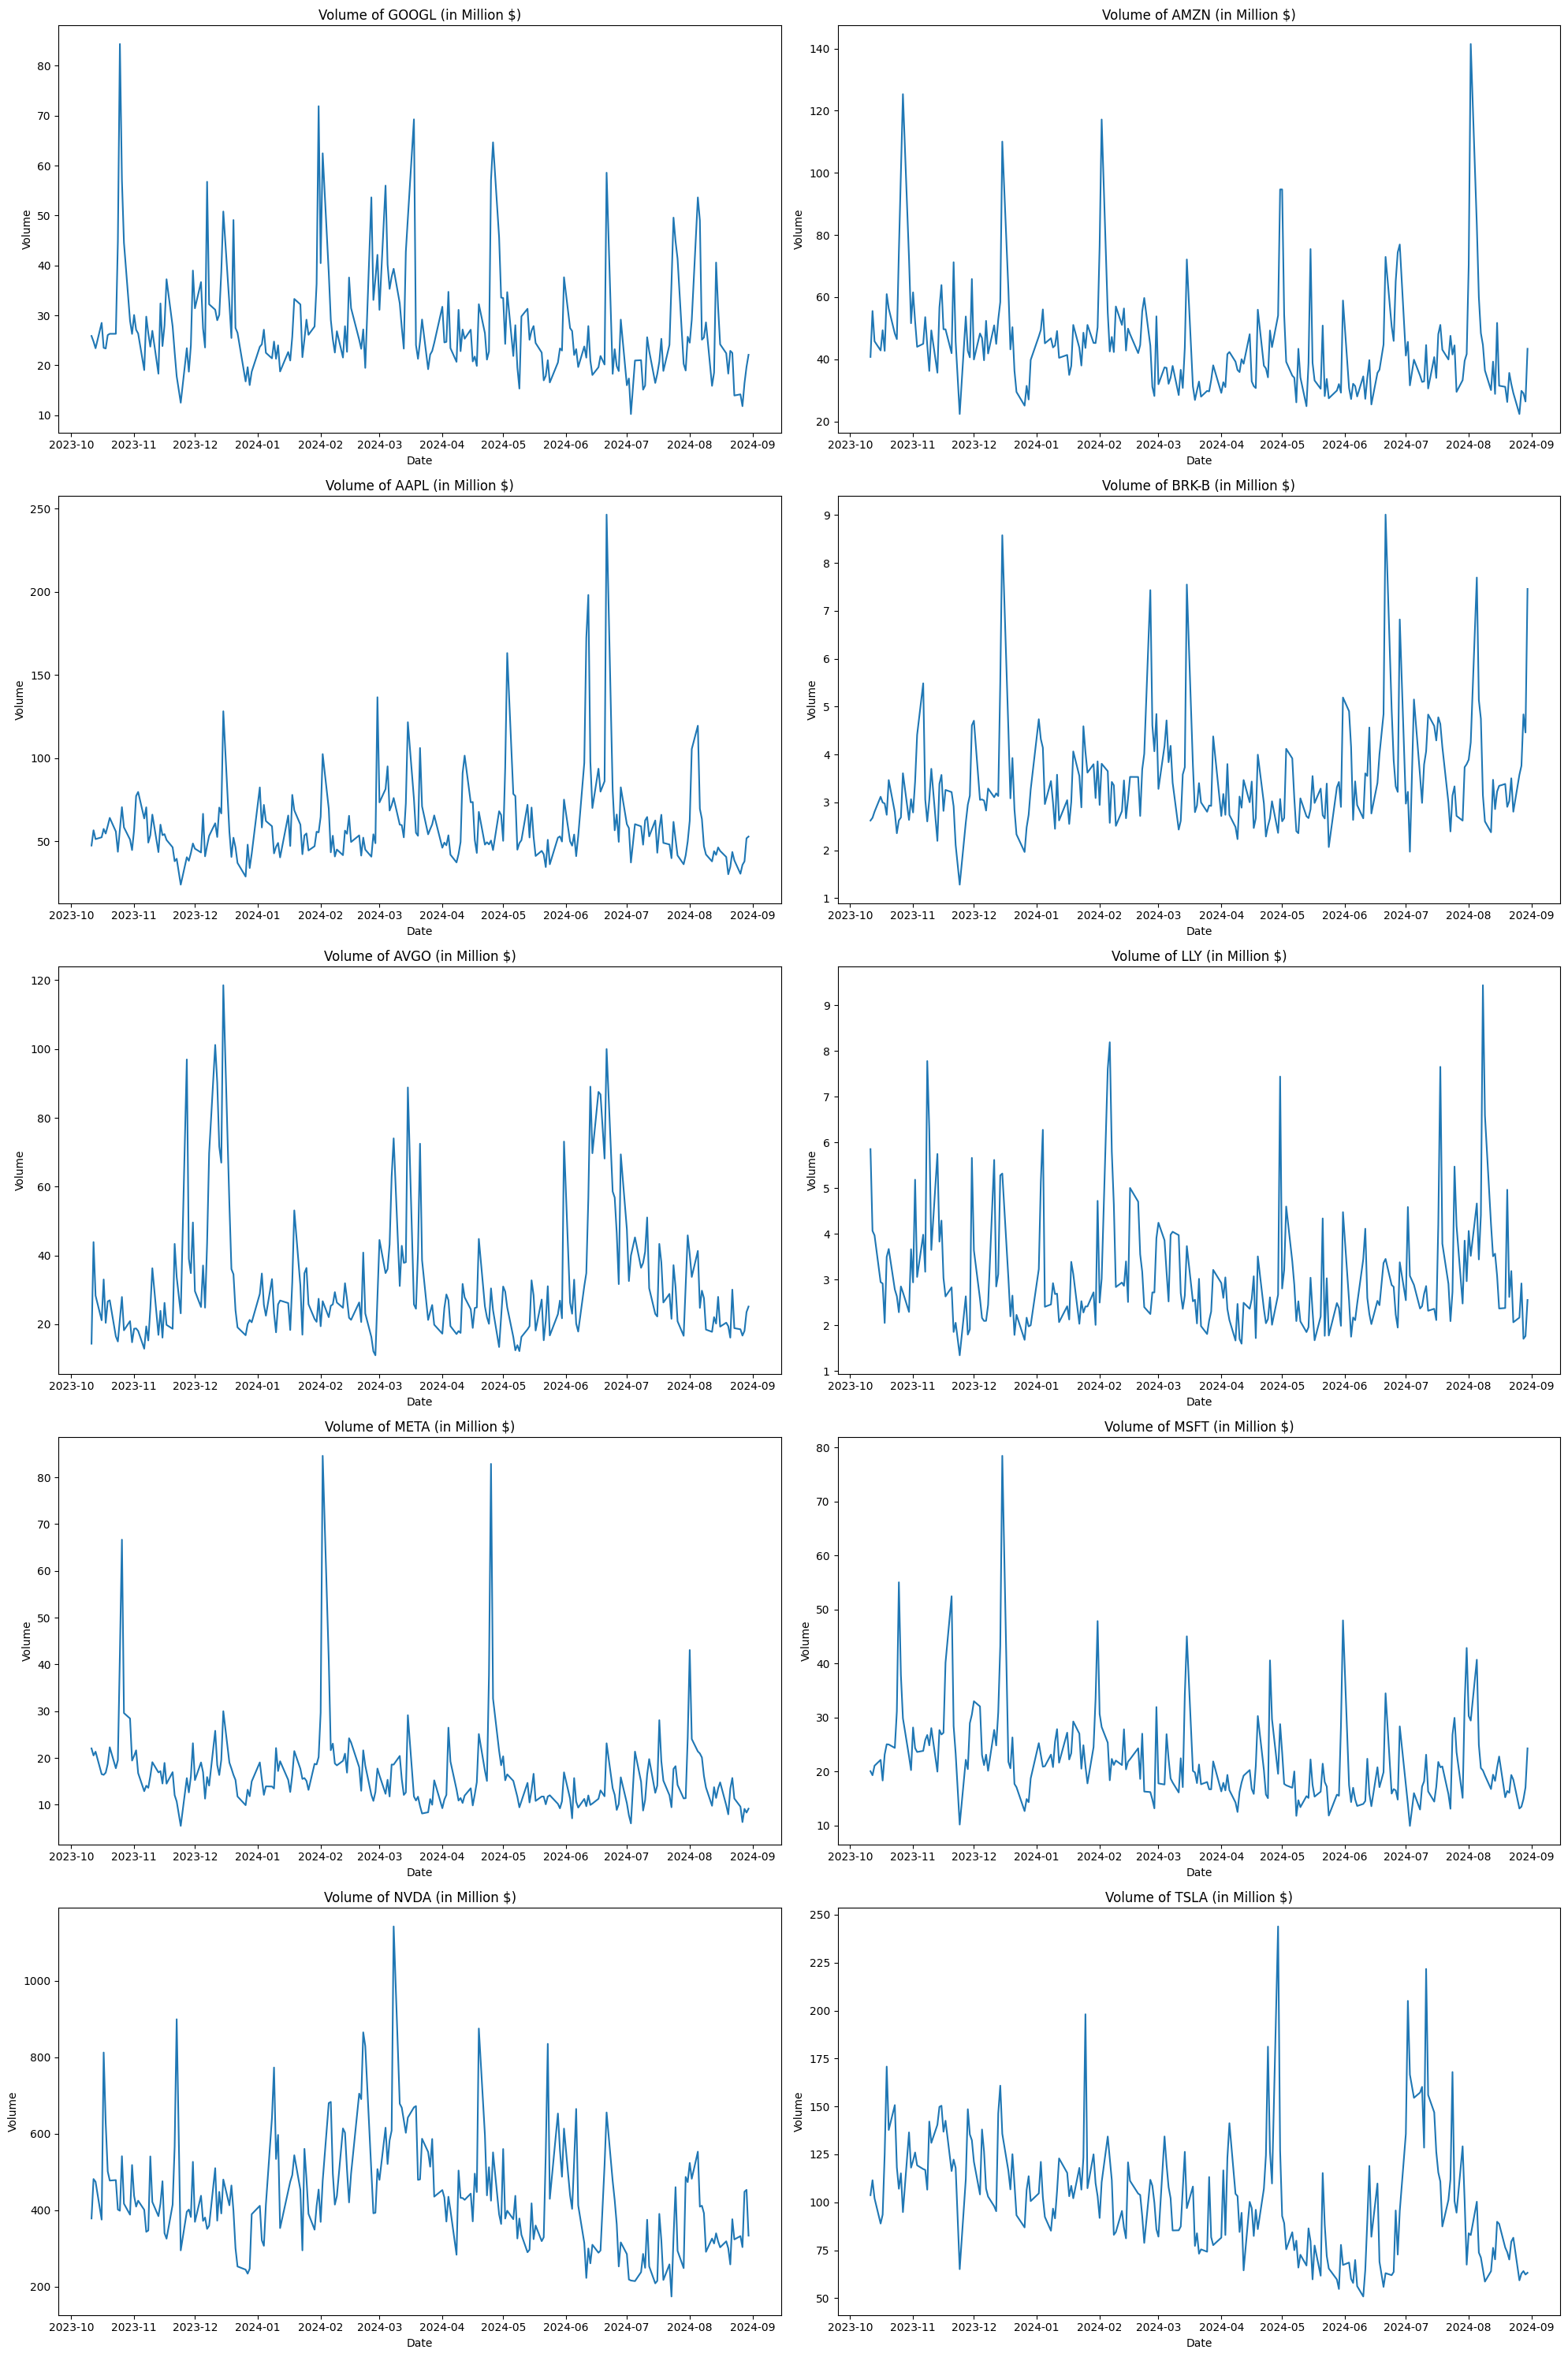

In [22]:
def volume_by_date_plot():
  df_stocks_filtered = top_ten_marketcap_companies(365)
  # normalize the volume by 1e6
  df_stocks_filtered["Volume"] /= 1e6
  # get the unique companies' symbols
  company_lis = df_stocks_filtered["Symbol"].unique()
  k = len(company_lis)
  number_of_row = math.ceil(k / 2)
  # init plot
  fig, ax = plt.subplots(number_of_row, 2, figsize = (20, 30))

  for index, company_symbol in enumerate(company_lis, start = 0):
    df_current_stocks_filtered = df_stocks_filtered[df_stocks_filtered["Symbol"] == company_symbol]
    # plot
    i = index // 2
    j = index % 2
    ax[i, j].plot(df_current_stocks_filtered["Date"], df_current_stocks_filtered["Volume"])
    ax[i, j].set_xlabel("Date")
    ax[i, j].set_ylabel("Volume")
    ax[i, j].set_title(f"Volume of {company_symbol} (in Million $)")

  plt.tight_layout()
  plt.show()

volume_by_date_plot()

## 4.3 Average Daily Volume by Company Plot

In [23]:
def average_daily_volume_by_company_plot():
  df_stocks_filtered = top_ten_marketcap_companies(365)
  df_stocks_filtered = df_stocks_filtered.groupby("Symbol").agg({"Volume": "mean"}).reset_index().sort_values(by = "Volume", ascending = False)
  fig = px.bar(
    df_stocks_filtered,
    x = "Symbol",
    y = "Volume",
    barmode = "stack",
    labels = {"Symbol": "Company", "Volume": "Average Daily Volume"},
    title = "Average Daily Volume by Company",
    template = template
  )
  fig.update_layout(showlegend = False)
  fig.show()

average_daily_volume_by_company_plot()

   Symbol                    Shortname
0    AAPL                   Apple Inc.
1    MSFT        Microsoft Corporation
2    NVDA           NVIDIA Corporation
3   GOOGL                Alphabet Inc.
5    AMZN             Amazon.com, Inc.
6    META         Meta Platforms, Inc.
7   BRK-B  Berkshire Hathaway Inc. New
8     LLY        Eli Lilly and Company
9    AVGO                Broadcom Inc.
10   TSLA                  Tesla, Inc.


#### Nvidia is having a relatively large daily volume compared to other companies in the same list of the top ten market capitalization companies. This means that over the last year, Nvida was doing very well in sales which is also reflected in the above closing price plot.

## 5. Conclusions
#### - The S&P 500 index has been increasing over the last ten years (from 2014 to now), making it a favorable invesment.
#### - The market capitalization of Technology sector is the largest while the market capitalization of Basic Materials sector is the smallest.
#### - In each sector, the market capitalization is highly affected by one big industry. For example in Communication Services, Internet Content & Information places the majority regarding market capitalization. And there is a huge discrepency between the industries' market cap in each sector.
#### - The majority of companies in the S&P 500 have less than 500 million full-time employees and less than 1 trillion dollars in market capitalization.
#### - Walmart and Amazon are the two that have the most full-time employees while Apple and Microsoft are the two with largest market capitalization.
#### - In the period of 2019 to 2023, the annual return rate of Technology and Energy perform relatively better than the rest of the sectors.
#### - Over last year (2023 - 2024), the adjusted closing price of the ten largest market capitalization companies is increasing gradually. 
#### - Over last year (2023 - 2024), the daily volumes are always above 2.5 million dollars. NVDA is having the largest average daily volume of 400 million while LLY is the lowest with 3.1 million. 